# Demo of code v2 on datasnippet

## Updates in version 2:
- Thompson Sampling added in algorithms.py
- GPU compatibility for both LinUCB and Thompson Samplling

## data preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
file_path = "/content/drive/MyDrive/Fellowship.AI/P1_bandit/data_snippet.csv"
df = pd.read_csv(file_path)
df.head()

,riid,opened,rev_3dv2,unsub,campaign_type,retention_score,recency_score,frequency_score
0,242697842,1,75.00,0,Dedicated,14.000000,1.637422,31
1,275469002,1,75.00,0,Dedicated,2.800000,0.000000,0
2,4319542,1,19.98,0,Dedicated,1.000000,0.084239,4
3,166170102,1,19.98,0,Dedicated,0.756757,0.010870,1
4,6998482,1,150.00,0,Dedicated,28.000000,1.845885,18


In [3]:
len(df)

6240490

In [4]:
num_data = 100000
indices = np.random.choice(len(df),size=num_data)
df_subset = df.iloc[indices]

In [5]:
vocab = {riid:i for i, riid in enumerate(df_subset.riid.unique())}

In [6]:
len(vocab)

87706

In [7]:
user_ids = df_subset.riid.apply(lambda x:vocab[x])
c_t = pd.get_dummies(df_subset.campaign_type)

In [8]:
datasource = pd.DataFrame()
datasource['user_ids'] = user_ids

In [9]:
datasource = pd.concat((datasource, c_t),axis=1)

In [10]:
datasource[["retention_score",	"recency_score",	"frequency_score"]] = df_subset[["retention_score",	"recency_score",	"frequency_score"]]

In [11]:
datasource

,user_ids,Brand,Collection,Core,Dedicated,Innovation Spotlight,New Arrivals,Other,Product Spotlight,Replen,Tops,Trend,retention_score,recency_score,frequency_score
508553,0,0,0,0,1,0,0,0,0,0,0,0,0.411765,0.000000,0
2651043,1,0,0,0,1,0,0,0,0,0,0,0,28.000000,3.099185,65
1775678,2,0,0,0,0,0,0,0,1,0,0,0,7.000000,0.940800,37
5412341,3,1,0,0,0,0,0,0,0,0,0,0,2.153846,0.062500,2
3935687,4,1,0,0,0,0,0,0,0,0,0,0,28.000000,4.975155,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2421076,87703,0,0,0,0,0,0,0,0,0,0,1,28.000000,3.554542,29
2439643,55639,1,0,0,0,0,0,0,0,0,0,0,14.000000,3.156832,47
2622314,87704,0,0,0,0,0,1,0,0,0,0,0,28.000000,4.543284,41
1160901,5132,0,0,0,1,0,0,0,0,0,0,0,1.333333,0.146739,6


In [12]:
rewardsource = pd.DataFrame()
rewardsource["reward_send"] = df_subset.opened * 1.2 - 0.2 + (df_subset.rev_3dv2 > 0) + df_subset.rev_3dv2/75.0 - 5.0*df_subset.unsub
rewardsource["reward_not_send"] = -rewardsource["reward_send"]

In [13]:
rewardsource

,reward_send,reward_not_send
508553,1.0,-1.0
2651043,1.0,-1.0
1775678,1.0,-1.0
5412341,-0.2,0.2
3935687,-0.2,0.2
...,...,...
2421076,1.0,-1.0
2439643,1.0,-1.0
2622314,1.0,-1.0
1160901,1.0,-1.0


In [14]:
opt_a = (rewardsource['reward_send'] < 0).astype(int)

In [15]:
opt_a

508553     0
2651043    0
1775678    0
5412341    1
3935687    1
          ..
2421076    0
2439643    0
2622314    0
1160901    0
4256137    1
Name: reward_send, Length: 100000, dtype: int64

## Run the code and compare with space bandits

In [16]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [17]:
import Wide_and_Deep_model
import Contextual_bandits_v2
import algorithms_v2
import importlib
importlib.reload(Wide_and_Deep_model)
importlib.reload(Contextual_bandits_v2)
importlib.reload(algorithms_v2)
Wide_Deep = Wide_and_Deep_model.Wide_Deep
ContextualBandit = Contextual_bandits_v2.ContextualBandit
LinUCB = algorithms_v2.LinUCB
TS = algorithms_v2.TS
import torch.optim as optim
import torch.nn as nn
import time

In [20]:
def run_CB(CB, contexts, reward_vectors, opt_actions, num_data_run = 20480, update_every=1, train_every=1024, train_batch_size=256, num_epoch=20, report_every=1024):
    start_time = time.time()
    train_start_index = 0
    pred_actions = []
    for t in range(num_data_run):
        context_source = np.array([contexts[t] for i in range(CB.action_dim)])
        reward_source = reward_vectors[t]
        pred_a = CB.run(context_source, reward_source)
        pred_actions.append(pred_a)

        if (t+1) % train_every == 0:
            CB.train(start_index=train_start_index, batch_size=train_batch_size, num_epoch=num_epoch)
            train_start_index = t + 1

        if (t+1) % update_every == 0:
            CB.algorithm.update_all(CB.dataset)

        if (t+1) % report_every == 0:
            print("{} data points seen in total; Time used for previous {} data points: {:.3f} seconds".format(t+1, report_every, (time.time() - start_time)))
            start_time = time.time()

    cum_rewards_pred_action = []
    cum_rewards_opt_action = []
    p_i = 0
    o_i = 0
    for i in range(num_data_run):
        p_i += reward_vectors[i][pred_actions[i]]
        o_i += reward_vectors[i][opt_actions[i]]
        cum_rewards_pred_action.append(p_i)
        cum_rewards_opt_action.append(o_i)
    
    return cum_rewards_pred_action, cum_rewards_opt_action

### Wide and Deep model + LinUCB + GPU 

In [21]:
embeddings = {'wide':[['user_id', len(vocab), 64]]}
model_LinUCB = Wide_Deep(1, 14, 2, embeddings=embeddings, deep_neurons=[128, 64]).to(device)
optimizer_LinUCB = optim.Adam(model_LinUCB.parameters(), lr=0.005)
loss_func = nn.MSELoss()
algorithm_LinUCB = LinUCB(device, model_LinUCB.z_dim, model_LinUCB.action_dim, delta=0.05)
CB_LinUCB = ContextualBandit(device, model_LinUCB, optimizer_LinUCB, loss_func, algorithm_LinUCB)

contexts = datasource.values
reward_vectors = rewardsource.values
opt_actions = opt_a.values

cum_rewards_pred_action_LinCB, cum_rewards_opt_action_LinCB = run_CB(CB_LinUCB, contexts, reward_vectors, opt_actions, num_data_run = 20480, update_every=1, train_every=1024, train_batch_size=256, num_epoch=20, report_every = 1024)

This is a wide and deep model.
1024 data points seen in total; Time used for previous 1024 data points: 3.593 seconds
2048 data points seen in total; Time used for previous 1024 data points: 3.267 seconds
3072 data points seen in total; Time used for previous 1024 data points: 3.306 seconds
4096 data points seen in total; Time used for previous 1024 data points: 3.273 seconds
5120 data points seen in total; Time used for previous 1024 data points: 3.346 seconds
6144 data points seen in total; Time used for previous 1024 data points: 3.453 seconds
7168 data points seen in total; Time used for previous 1024 data points: 3.508 seconds
8192 data points seen in total; Time used for previous 1024 data points: 3.528 seconds
9216 data points seen in total; Time used for previous 1024 data points: 3.557 seconds
10240 data points seen in total; Time used for previous 1024 data points: 3.515 seconds
11264 data points seen in total; Time used for previous 1024 data points: 3.558 seconds
12288 data

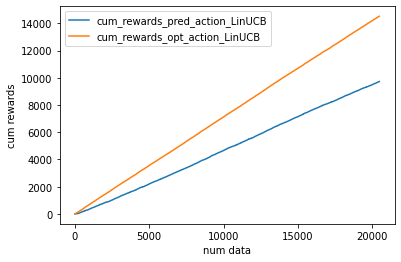

In [22]:
import matplotlib.pyplot as plt
plt.plot(cum_rewards_pred_action_LinCB, label = 'cum_rewards_pred_action_LinUCB')
plt.plot(cum_rewards_opt_action_LinCB, label = 'cum_rewards_opt_action_LinUCB')
plt.legend()
plt.xlabel('num data')
_ = plt.ylabel('cum rewards')

### Wide and Deep model + Thompson Sampling + GPU

In [24]:
embeddings = {'wide':[['user_id', len(vocab), 64]]}
model_TS = Wide_Deep(1, 14, 2, embeddings=embeddings, deep_neurons=[128, 64]).to(device)
optimizer_TS = optim.Adam(model_TS.parameters(), lr=0.005)
loss_func = nn.MSELoss()
algorithm_TS = TS(model_TS.z_dim, model_TS.action_dim, lambda_=0.25)
CB_TS = ContextualBandit(device, model_TS, optimizer_TS, loss_func, algorithm_TS)

cum_rewards_pred_action_TS, cum_rewards_opt_action_TS = run_CB(CB_TS, contexts, reward_vectors, opt_actions, num_data_run = 20480, update_every=1, train_every=1024, train_batch_size=256, num_epoch=20, report_every = 1024)

This is a wide and deep model.


/content/algorithms_v2.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  beta = np.random.multivariate_normal(mu, cov)


1024 data points seen in total; Time used for previous 1024 data points: 23.070 seconds
2048 data points seen in total; Time used for previous 1024 data points: 21.860 seconds
3072 data points seen in total; Time used for previous 1024 data points: 23.164 seconds
4096 data points seen in total; Time used for previous 1024 data points: 22.882 seconds
5120 data points seen in total; Time used for previous 1024 data points: 22.835 seconds
6144 data points seen in total; Time used for previous 1024 data points: 23.532 seconds
7168 data points seen in total; Time used for previous 1024 data points: 22.809 seconds
8192 data points seen in total; Time used for previous 1024 data points: 22.826 seconds
9216 data points seen in total; Time used for previous 1024 data points: 23.667 seconds
10240 data points seen in total; Time used for previous 1024 data points: 23.211 seconds
11264 data points seen in total; Time used for previous 1024 data points: 23.263 seconds
12288 data points seen in tota

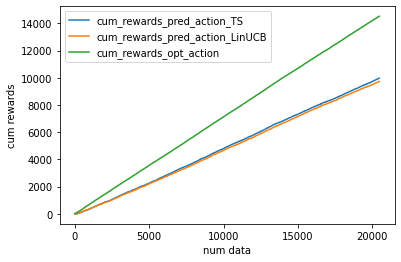

In [25]:
plt.plot(cum_rewards_pred_action_TS, label = 'cum_rewards_pred_action_TS')
plt.plot(cum_rewards_pred_action_LinCB, label = 'cum_rewards_pred_action_LinUCB')
plt.plot(cum_rewards_opt_action_TS, label = 'cum_rewards_opt_action')
plt.legend()
plt.xlabel('num data')
_ = plt.ylabel('cum rewards')

### Space Bandits

In [26]:
!pip install space-bandits

  Created wheel for space-bandits: filename=space_bandits-0.0.992-cp36-none-any.whl size=17441 sha256=056a762bcfc24d92c17f5193765578d4103b11b491b91e71fbb01a1e2df3e2e4
  Stored in directory: /root/.cache/pip/wheels/a7/0c/a7/4bae68f8e665b4c68e7cb7ae7fff88269f3551a4b56b598a42
Successfully built space-bandits


In [29]:
from space_bandits import NeuralBandits

model_sb = NeuralBandits(2, 14, training_freq_network=1024, training_epochs=80, batch_size=256)
start_time = time.time()
pred_actions = []
for i in range(20480):
    context = contexts[:,1:][i]
    action = model_sb.action(context)
    pred_actions.append(action)
    reward = reward_vectors[i][action]
    model_sb.update(context, action, reward)
    if (i+1) % 1024 == 0:
        print("{} data points seen in total; Time used for previous {} data points: {:.3f} seconds".format(i+1, 1024, (time.time() - start_time)))
        start_time = time.time()

Training neural_model-bnn for 80 steps...
1024 data points seen in total; Time used for previous 1024 data points: 7.699 seconds
Training neural_model-bnn for 80 steps...
2048 data points seen in total; Time used for previous 1024 data points: 10.427 seconds
Training neural_model-bnn for 80 steps...
3072 data points seen in total; Time used for previous 1024 data points: 11.594 seconds
Training neural_model-bnn for 80 steps...
4096 data points seen in total; Time used for previous 1024 data points: 12.975 seconds
Training neural_model-bnn for 80 steps...
5120 data points seen in total; Time used for previous 1024 data points: 14.563 seconds
Training neural_model-bnn for 80 steps...
6144 data points seen in total; Time used for previous 1024 data points: 15.614 seconds
Training neural_model-bnn for 80 steps...
7168 data points seen in total; Time used for previous 1024 data points: 16.876 seconds
Training neural_model-bnn for 80 steps...
8192 data points seen in total; Time used for pre

In [30]:
cum_rewards_pred_action_sb = []
cum_rewards_opt_action_sb = []
p_i = 0
o_i = 0
for i in range(20480):
    p_i += reward_vectors[i][pred_actions[i]]
    o_i += reward_vectors[i][opt_actions[i]]
    cum_rewards_pred_action_sb.append(p_i)
    cum_rewards_opt_action_sb.append(o_i)

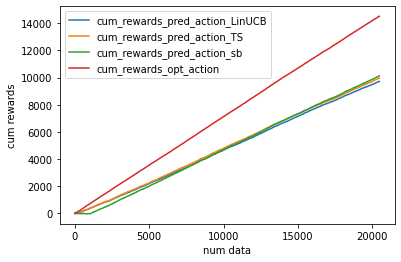

In [33]:
plt.plot(cum_rewards_pred_action_LinCB, label = 'cum_rewards_pred_action_LinUCB')
plt.plot(cum_rewards_pred_action_TS, label = 'cum_rewards_pred_action_TS')
plt.plot(cum_rewards_pred_action_sb, label = 'cum_rewards_pred_action_sb')
plt.plot(cum_rewards_opt_action_sb, label = 'cum_rewards_opt_action')
plt.legend()
plt.xlabel('num data')
_ = plt.ylabel('cum rewards')